# Functions to denormlize scRNA-seq data

> The main functions of denormlizing the normlized scRNA-seq data

In [ ]:
#| default_exp denorm

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

In [ ]:
#| export
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
from scipy.sparse import diags,issparse,csr_matrix,isspmatrix_csr
from scipy.io import mmwrite
from tqdm import tqdm
from pathlib import Path
from fastcore.script import *
import logging
import multiprocessing

logging.getLogger().setLevel(logging.INFO)

## Functions

In [ ]:
#| export
@call_parse
def scdenorm(fin:str, # The input file or AnnData
             fout:str = None, # The path of output file if provided
             gxc:bool = False, # Change to True if the data is stored with gene by cell
             base:float = None, # Give the base if it is known
             cont:float = 1.0, # The constant plused after scaling
             rint:bool = True, # Round elements of the result to the nearest integer
             cutoff:float = 0.001, 
             verbose:int = 0):
    """
    denormalize takes a cell * gene expression matrix that has been normalized according to single-cell RNA 
    sequencing preprocessing procedure and return a recovered count matrix by reversing the logarithmization step
    and then the total-count normalization step utilizing the unscale function. If the imput matrix is not 
    normalized by first total-count scaling then logarithmization, then the function produces an error
    indicating so. We also handle matrices that have not been logarithmized.
    denormalize: csr_matrix -> csr_matrix
    """
    levels = [logging.WARNING, logging.INFO, logging.DEBUG]
    logging.getLogger().setLevel(levels[verbose] if verbose<3 else logging.INFO)
    try:
        fin=Path(fin)
        logging.info(f'Reading input file: {fin}')
        ad=sc.read(fin)
    except:
        ad=fin.copy()
    #make sure ad.X have data and is dense matrix
    if ad.shape[0]<1 or ad.shape[1]<1:
        raise Exception("The anndata don't have cells or genes")
    if issparse(ad.X):
        ad.X.eliminate_zeros() #remove potential 0s.
        if not isspmatrix_csr(ad.X):
            ad.X = csr_matrix(ad.X)
    else:
        ad.X = csr_matrix(ad.X)

    arr = ad.X.data
    if np.array_equal(arr, np.round(arr)):
        logging.info(f"All counts are integers")
        counts=ad.X
    else:
        logging.info(f'The dimensions of this data are {ad.shape}.')
        if gxc: #if data is gene by cell
            logging.info(f'The data is gene by cell. It is transposed to cell by gene {ad.T.shape}')
            ad=ad.T
        smtx=ad.X  #must be cell by gene
        
        #2.de-transformation
        #select base and denormlize
        if base is None:
            logging.info('select base')
            base,cont = select_base(smtx.getrow(0).data.copy(),cont,cutoff)
            if base is None and cont is None:
                #fully auto detect
                base,cont = auto_detect(smtx,1e-6)
            
        
        #3.de-normalization
        logging.info(f'denormlizing ...the base is {base}')
        if check_unscale(smtx.getrow(0).data.copy(),base,cont,cutoff):
            counts,success_cells=unscale_mat(smtx,base,cont,cutoff,rint)
            ad=ad[success_cells].copy() #filter failed cells
        else:
            logging.error('Denormlization has failed. Output the orignal data')
            counts=smtx
        if fout is None:
            counts.data=counts.data.astype(ad.X.dtype)
            ad.X=counts
            return ad
       
    #write output
    logging.info(f'Writing output file: {fout}')
    if fout.endswith('.mtx'):
        mmwrite(fout, counts, field = 'integer')
    else:
        counts.data=counts.data.astype(ad.X.dtype)
        ad.X=counts
        ad.write(fout)    

In [ ]:
#| export
def solve_bc(p):
    return sum((np.power(p[0],y2)-2*np.power(p[0],y1)+p[1])**2)

In [ ]:
#| export
def auto_detect(smtx,cutoff):
    ys=[]
    for c_idx in range(100):
        try:
            N = 2
            c = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(c.value_counts().sort_index().head(N).index)
            ys.append(y)
        except:
            print(c_idx)

    ys=np.array(ys)

    y1=ys[:,0]
    y2=ys[:,1]

    res = minimize(solve_bc, [3,0], method='Nelder-Mead', tol=1e-6)
    return res

In [ ]:
#| export
def unscale_mat(smtx,base=np.e,cont=1,cutoff=0.05,rint=True,gpu=False):
    """
    unscale takes a cell * gene expression matrix that has been quality-controlled and scaled according to 
    single-cell RNA sequencing preprocessing procedure and return a recovered count matrix 
    by finding the scaling factor for each cell,
    or produce an error indicating the matrix has not been processed by our assumption.
    unscale: csr_matrix -> csr_matrix
    """
    scaled_counts=smtx.copy()
    if base is not None:
        scaled_counts.data = base ** scaled_counts.data - cont
    else:
        #without transformation
        scaled_counts.data = scaled_counts.data - cont
        
    #get scale factors
    scaling_factors,success_cells=[],[]
    for i in tqdm(range(scaled_counts.shape[0])):
        try:
            scaling_factors.append(get_scaling_factor(scaled_counts.getrow(i).data,cutoff))
            success_cells.append(i)
        except:
            logging.warning(f"Warning:The cell {i} fails to denormlize, and be deleted")
    
    # Remove failed cells from the scaled_counts matrix
    scaled_counts=scaled_counts[success_cells,:]
    if gpu:
        pass
    else:
        scaling_factors = diags(scaling_factors)
        counts = scaling_factors*scaled_counts
    if rint:
        counts=counts.rint()
    counts.sort_indices()  #keep the increase order of indices
    return counts,success_cells

def select_base(x,cont=1,cutoff=0.05,plot=False):
    for b in [np.e,None,2,10]:
        print('b is', b)
        if cont is None:
            for c in [1,0.1,0.01,0.001,0]:
                if check_unscale(x,b,c,cutoff,plot):
                    return b,c
        else:
            if check_unscale(x,b,cont,cutoff,plot):
                return b,cont
    return None,None

def check_unscale(x,base=np.e,cont=1,cutoff=0.05,plot=True):
    if base is not None:
        x=base**x-cont
    else:
        x=x-cont  #without transformation
    try:
        get_scaling_factor(x,cutoff)
        return True
    except:
        #logging.error(f'The base {base} is not match with the data.')
        if plot:
            check_plot(pd.Series(x),base)
    return False

def get_scaling_factor_2(x,cutoff=0.05):
    """
    get_scaling_factor takes a cell vector and its index in the gene expression matrix 
    that has been scaled according to single-cell RNA sequencing preprocessing procedure 
    and return the scaling factor for the cell,
    or produce an error indicating the cell has not been processed by our assumption.
    get_scaling_factor: ndarray Nat (Num) -> Num
    """
    x=pd.Series(x).value_counts().sort_index()
    if x.shape[0]<2:
        raise ValueError(f"Cell has one value. {x}")
    if not np.alltrue(x.index[:2]==x.sort_values(ascending=False).index[:2]):
        raise ValueError(f"TOP 2 counts and ranks are not consistent. {x}")
    x=np.array(x.index)
    xm=x[0]
    x=x/xm
    if np.abs(x-x.round()).mean()>cutoff:
        raise 
    return 1/xm

def get_scaling_factor_1(x,cutoff=0.05):
    ''' x is a normlized cell '''
    x=x.astype('float16')
    y=np.array(x.value_counts().sort_index().head(2).index)
    if np.abs(y[0]-y[1]/2)>10**-5:
        raise
    return 1/y[0]

def get_scaling_factor(x,cutoff=0.05):
    """
    get_scaling_factor takes a cell vector and its index in the gene expression matrix 
    that has been scaled according to single-cell RNA sequencing preprocessing procedure 
    and return the scaling factor for the cell,
    or produce an error indicating the cell has not been processed by our assumption.
    get_scaling_factor: ndarray Nat (Num) -> Num
    """
    x=pd.Series(x)
    xm=x.min()
    x=x/xm
    if np.abs(x-x.round()).mean()>cutoff:
        raise 
    return 1/xm

In [ ]:
#| export
def check_plot(c,idx,n=10):
    """
    Check_plot takes a cell vector and its index in the gene expression matrix and produce a plot of the first
    N most frequent values against their ranks. Such a plot is used for error-checking in the unscaling process.
    """
    y = np.array(c.value_counts().sort_index().head(n).index)
    x = np.arange(1, n+1)
    plt.scatter(x, y, label=f'Base {idx}')
    plt.legend()
    plt.xlabel('Rank in cell histogram')
    plt.ylabel('Scaled count')
    plt.xticks(x)
    plt.show()

## create test data

In [ ]:
ad=sc.datasets.pbmc3k()

In [ ]:
ad=ad.concatenate([ad for _ in range(10)])

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [ ]:
ad=ad.concatenate([ad for _ in range(10)])

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [ ]:
ad=ad.concatenate([ad for _ in range(10)])

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [ ]:
ad

AnnData object with n_obs × n_vars = 3593700 × 32738
    obs: 'batch'
    var: 'gene_ids'

In [ ]:
sc.pp.normalize_total(ad, target_sum=1e4)
#sc.pp.log1p(ad)
smtx = ad.X.tocsr().asfptype()

In [ ]:
smtx = ad.X.tocsr().asfptype()

In [ ]:
scaled_counts=smtx

In [ ]:
i,cutoff=0,0.001
get_scaling_factor(scaled_counts.getrow(i).data, cutoff)

0.24209999655982023

In [ ]:
%%time
scaling_factors,success_cells=[],[]
for i in tqdm(range(scaled_counts.shape[0])):
    try:
        scaling_factors.append(get_scaling_factor(scaled_counts.getrow(i).data,cutoff))
        success_cells.append(i)
    except:
        logging.warning(f"Warning:The cell {i} fails to denormlize, and be deleted")

100%|██████████| 3593700/3593700 [20:53<00:00, 2867.61it/s]

CPU times: user 20min 23s, sys: 33.2 s, total: 20min 56s
Wall time: 20min 53s


In [ ]:
%%time
scaling_factors,success_cells=[],[]
for i in tqdm(range(scaled_counts.shape[0])):
    try:
        scaling_factors.append(get_scaling_factor_2(scaled_counts.getrow(i).data,cutoff))
        success_cells.append(i)
    except:
        logging.warning(f"Warning:The cell {i} fails to denormlize, and be deleted")

100%|██████████| 2700/2700 [00:01<00:00, 2064.87it/s]

CPU times: user 1.31 s, sys: 11.2 ms, total: 1.32 s
Wall time: 1.31 s


In [ ]:
%%time
scaling_factors = diags(scaling_factors)
counts = scaling_factors*scaled_counts

CPU times: user 38.4 s, sys: 18.2 s, total: 56.6 s
Wall time: 56.7 s


In [ ]:
counts

<3593700x32738 sparse matrix of type '<class 'numpy.float64'>'
	with 3043842604 stored elements in Compressed Sparse Row format>

In [ ]:
counts.data

array([4.        , 1.        , 9.99999954, ..., 1.        , 1.        ,
       1.        ])

In [ ]:
counts.data

array([4.        , 1.        , 9.99999954, ..., 1.        , 1.        ,
       1.        ])

In [ ]:
scaled_counts

<326700x32738 sparse matrix of type '<class 'numpy.float32'>'
	with 276712964 stored elements in Compressed Sparse Row format>

In [ ]:
counts.data

array([3.59520866, 0.89880217, 8.98802125, ..., 0.34156169, 0.34156169,
       0.34156169])

In [ ]:
smtx.data

array([1.6352079, 1.6352079, 2.2258174, ..., 1.7980369, 1.7980369,
       2.779648 ], dtype=float32)

In [ ]:
x=smtx.getrow(0).data

x=pd.Series(x).value_counts().sort_index()

x=np.exp(np.array(x.index))-1

x=x/(x[0]+0.1)

np.abs(x-x.round()).mean()

0.24593542762363435

In [ ]:
np.alltrue(x.index[:2]==x.sort_values(ascending=False).index[:2])

True

In [ ]:
pd.Series(x).value_counts().sort_index().index==pd.Series(x).value_counts().sort_values(ascending=False).index

array([ True,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False])

In [ ]:
ValueError(f"Invalid value provided.{x}")

ValueError('Invalid value provided.1.635208    556\n2.225817     77\n2.594626     22\n2.863463     17\n3.075127     24\n3.249721      6\n3.398316      6\n3.527660      6\n3.642174      1\n3.744911     10\n3.838070      7\n3.923285      4\n4.001806      3\n4.074607      3\n4.142466      5\n4.206011      1\n4.265759      3\n4.322136      4\n4.375505      4\n4.474390      1\n4.520391      4\n4.564370      2\n4.646918      2\n4.723168      1\n4.759218      1\n4.794014      1\n4.951860      1\n5.008626      2\n5.035844      2\n5.137864      1\n5.208081      1\n5.273690      1\n5.315154      1\n5.752318      1\ndtype: int64')

### Testing check_unscale

In [ ]:
x=smtx.getrow(0).data

In [ ]:
check_unscale(x)

True

ERROR:root:The base 2 is not match with the data.


False

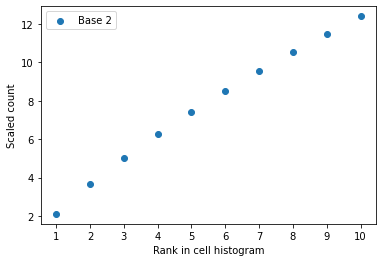

In [ ]:
check_unscale(x,base=2)

### Testing scdenorm

In [ ]:
mmwrite('data/scaled.mtx', smtx[1:10,])

In [ ]:
ad1=sc.read('data/scaled.mtx')

In [ ]:
ad1

AnnData object with n_obs × n_vars = 9 × 32738

In [ ]:
mmwrite('scaled_tran.mtx', smtx.transpose())

#### 1.Testing unscale_mat
- input is a sparse matrix with cell by gene
- output is a sparse matrix after denormalization

In [ ]:
unscale_mat(ad1.X)

100%|██████████| 9/9 [00:00<00:00, 515.05it/s]


(<9x32738 sparse matrix of type '<class 'numpy.float64'>'
 	with 7403 stored elements in Compressed Sparse Row format>,
 [0, 1, 2, 3, 4, 5, 6, 7, 8])

#### 2.Testing scdenorm with right base

In [ ]:
scdenorm('data/scaled.mtx',fout='data/scd_scaled.h5ad',base=np.e, verbose=1)

INFO:root:Reading input file: data/scaled.mtx
INFO:root:The dimensions of this data are (9, 32738).
INFO:root:denormlizing ...
100%|██████████| 9/9 [00:00<00:00, 750.87it/s]
INFO:root:Writing output file: data/scd_scaled.h5ad


#### 3.Testing scdenorm with wrong base

INFO:root:Reading input file: data/scaled.mtx
INFO:root:The dimensions of this data are (9, 32738).
INFO:root:denormlizing ...
ERROR:root:The base 2 is not match with the data.
ERROR:root:Denormlization has failed. Output the orignal data
INFO:root:Writing output file: data/scd_scaled.h5ad


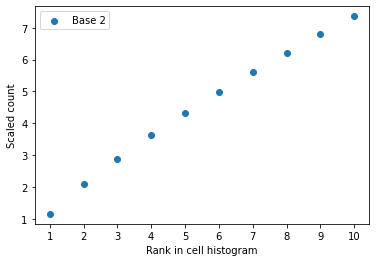

In [ ]:
scdenorm('data/scaled.mtx',fout='data/scd_scaled.h5ad',base=2, verbose=1)

#### 4.Testing scdenorm without base

In [ ]:
scdenorm('data/scaled.mtx',fout='data/scd_scaled.h5ad', verbose=1)

INFO:root:Reading input file: data/scaled.mtx
INFO:root:The dimensions of this data are (9, 32738).
INFO:root:select base
INFO:root:denormlizing ...
100%|██████████| 9/9 [00:00<00:00, 1674.67it/s]
INFO:root:Writing output file: data/scd_scaled.h5ad


In [ ]:
scdenorm('data/scaled.mtx', verbose=1)

INFO:root:Reading input file: data/scaled.mtx
INFO:root:The dimensions of this data are (9, 32738).
INFO:root:select base
INFO:root:denormlizing ...
100%|██████████| 9/9 [00:00<00:00, 1773.41it/s]


View of AnnData object with n_obs × n_vars = 9 × 32738

In [ ]:
scdenorm(ad1, verbose=1)

INFO:root:The dimensions of this data are (9, 32738).
INFO:root:select base
INFO:root:denormlizing ...
100%|██████████| 9/9 [00:00<00:00, 967.00it/s]


View of AnnData object with n_obs × n_vars = 9 × 32738